In [1]:
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal # MVN not univariate

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import time

np.random.seed(7)


np.set_printoptions(suppress=True)

file_path = "data.csv"
df = pd.read_csv(file_path, index_col='year')

file_path = "tracks_features.csv"
df2 = pd.read_csv(file_path, index_col='year')

df.drop(['artists','id', 'name', 'release_date','popularity' ], axis = 1, inplace = True)
# df2.drop(['artists','id', 'name', 'release_date', 'album_id','artist_ids', 'time_signature',\
#           'track_number', 'disc_number', 'album' ], axis = 1, inplace = True)
# df = pd.concat([df,df2])
# df.drop(['mode','explicit'], axis = 1, inplace = True)
# print(df)

### Only look at decades from 50s to 10s (2020 not included)
l_drop = np.arange(1921,1950)
l_drop = np.append(l_drop,2020)
# drop_vals = np.array([0,1900,1908,1909,1917,1920])
# l_drop = np.concatenate((l_drop,drop_vals))


df.drop(labels=l_drop, axis=0, inplace = True)

enc = LabelEncoder()
labels = df.index
standardized_labels = np.array(labels)
enc.fit(df.index.unique())



lmao = df.index
y = enc.transform(standardized_labels)
Y = enc.transform(np.unique(standardized_labels))

y_decade = y//10
Y_decade = np.unique(y_decade)

# enc.fit(df['explicit'].unique())
# df['explicit'] = enc.transform(df['explicit'])


df.set_index(y_decade, inplace=True)

aa = df.index.value_counts().sort_index().to_numpy()
priors = aa/len(df.index)
check = np.sum(priors)
class_priors = np.diag(priors)
num_classes = len(Y_decade)
# print(df)


N = len(df)
print('Labels:',Y_decade)
print('Total Datapoints:',N)
print("Counts Per Class:")
print(df.index.value_counts().sort_index())
df.head()

Labels: [0 1 2 3 4 5 6]
Total Datapoints: 139850
Counts Per Class:
0    19950
1    20000
2    20000
3    20000
4    20000
5    20000
6    19900
dtype: int64


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.782,0.633,106471,0.2610,1,0.0000,1,0.235,-16.389,1,0.7970,167.679,0.655
0,0.988,0.420,232933,0.0909,0,0.7860,10,0.104,-19.388,1,0.0409,123.089,0.227
0,0.993,0.394,177981,0.2580,0,0.0770,5,0.153,-9.779,0,0.1100,74.761,0.340
0,0.730,0.618,125300,0.2720,1,0.0000,6,0.146,-18.515,1,0.7310,67.141,0.449
0,0.993,0.475,188600,0.4070,0,0.0134,9,0.116,-13.011,1,0.0492,74.130,0.594


In [2]:
def regularized_cov(X, lambda_reg):
    n = X.shape[0]
    sigma = np.cov(X)
    # Selecting the regularization parameter should be performed using CV and a separate data subset
    # As I only went by training set performance (overfitting) in this problem, I settled on lambda=1/n
    sigma += lambda_reg * np.eye(n)
    return sigma

covariance = df.std()
mean = df.mean()
X = (df-df.mean())/df.std()
# print(X)
mu = X.groupby([X.index]).mean().to_numpy()
n = mu.shape[1]
Sigma = np.array([regularized_cov(X[y_decade == l].T,(1/n)) for l in range(num_classes)])
# Sigma = np.array([np.cov(X[y_decade == l].T) for l in range(num_classes)])
# print(mu)
# print(Sigma)


In [3]:
C = len(priors)
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[j], Sigma[j]) for j in range(C)])
# print(np.max(class_cond_likelihoods))

# Class Posterior
# P(yj | x) = p(x | yj) * P(yj) / p(x)
class_posteriors = class_priors.dot(class_cond_likelihoods)

decisions = np.argmax(class_posteriors, axis=0)

sample_class_counts = np.array([sum(y == j) for j in Y_decade])


conf_mat = np.zeros((C, C))
display_mat = np.zeros((C,C))
for i in range(C): # Each decision option
    for j in range(C): # Each class label
        ind_ij = np.argwhere((decisions==Y_decade[i]) & (y_decade==Y_decade[j]))
        display_mat[i, j] = len(ind_ij) # Average over class sample count
        conf_mat[i, j] = len(ind_ij)/sample_class_counts[j]

print("Total Number of Samples:",np.sum(display_mat))
print("Confusion matrix:")
print(display_mat.astype(int))
# print(1950+(Y_decade*10))

correct_class_samples = np.sum(np.diag(display_mat))
print("Total Mumber of Misclassified Samples: {}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
print("Accuracy:",1-prob_error)

Total Number of Samples: 139850.0
Confusion matrix:
[[ 7134  2696   992  1148  1059   900   838]
 [11025 11410  5918  3228  3780  3213  2440]
 [ 1493  5355 11046  9441  7457  5191  3073]
 [   91   304  1463  4436  3030  1978  1218]
 [    8     9    67   213   409   132    75]
 [   18   135   339   985  1651  4752  4605]
 [  181    91   175   549  2614  3834  7651]]
Total Mumber of Misclassified Samples: 93012.0
Empirically Estimated Probability of Error: 0.6651
Accuracy: 0.3349159814086522


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y_decade, test_size = 0.30)


start = time.time()


clf = RandomForestClassifier(n_estimators = 100)
print('done')

clf.fit(X_train, y_train)
print('done')

feature_imp = pd.Series(clf.feature_importances_, index = df.columns).sort_values(ascending = False)
print('done')

print(feature_imp)


y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))



stop = time.time()
print()
print('Time to run (sec): ', stop - start) 
print('Time to run (min): ', (stop - start)/60) 

done
done
done
acousticness        0.125656
loudness            0.118565
duration_ms         0.102303
energy              0.096222
valence             0.087639
danceability        0.086591
speechiness         0.084844
tempo               0.080085
liveness            0.075495
instrumentalness    0.067957
key                 0.047926
explicit            0.014459
mode                0.012258
dtype: float64

ACCURACY OF THE MODEL:  0.47906089858181383

Time to run (sec):  22.790042877197266
Time to run (min):  0.37983404795328773


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Utility to visualize PyTorch network and shapes
from torchsummary import summary
from sklearn.model_selection import KFold # Important new include
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

torch.manual_seed(7)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.device(device)

cuda


In [6]:
class TwoLayerMLP(nn.Module):
    # Two-layer MLP (not really a perceptron activation function...) network class
    
    def __init__(self, input_dim, hidden_dim, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from input_dim (n) -> hidden_layer_dim
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        #Hidden layer
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layer again fully connected mapping from hidden_layer_dim -> outputs_dim (C)
        self.output_fc = nn.Linear(hidden_dim, C)
        # Log Softmax (faster and better than straight Softmax)
        # dim=1 refers to the dimension along which the softmax operation is computed
        # In this case computing probabilities across dim 1, i.e., along classes at output layer
        self.log_softmax = nn.LogSoftmax(dim=1) 
        
    # Don't call this function directly!! 
    # Simply pass input to model and forward(input) returns output, e.g. model(X)
    def forward(self, X):
        # X = [batch_size, input_dim (n)]
        X = self.input_fc(X)
        
        # Non-linear activation function, e.g. ReLU (default good choice)
        # Could also choose F.softplus(x) for smooth-ReLU, empirically worse than ReLU
        X = F.relu(X)
        X = self.hidden_layer(X)
        # X = [batch_size, hidden_dim]
        
        # Add another hidden layer
        X = F.relu(X)
        X = self.hidden_layer(X)


        # Connect to last layer and output 'logits'
        X = self.output_fc(X)
        # Squash logits to probabilities that sum up to 1
        y = self.log_softmax(X)
        return y


In [7]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):

    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
#     model = model.to(device)
#     data = data.to(device)
#     print(model.device())
    
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model
    
    
def model_predict(model, data, labels):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
#     model.to(device)
    labels.to(device)

    model.eval()
    N = len(data)
#     print(N)
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().cpu().numpy()
        Z = np.argmax(predicted_labels, 1)
#     print(labels)
    conf_mat = confusion_matrix(Z, labels.cpu())
    correct_class_samples = np.sum(np.diag(conf_mat))
    prob_error = 1 - (correct_class_samples / N)
#     print(conf_mat)
#     print("Total Number of Misclassified Samples: {:d}".format(N - correct_class_samples))
#     print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
#     print()
    return Z, prob_error, conf_mat

# Z, acc = model_predict(model,X_tensor[0],labels[0])
# print(acc)

def neuron_cross_validation(X,labels,X_tensor,l_tensor):#,Xtest,labelsTest):

    K = 10
    kf = KFold(n_splits=K, shuffle=True)
    start = 1
    trials = 64
    neurons = np.arange(start, start+trials, 1)
    n_hidden = len(neurons)
    
#     X = X.to(device)
#     labels = labels.to(device)
    X_tensor = X_tensor.to(device)
    l_tensor = l_tensor.to(device)
    
    # Store predictions per degree using ordered X samples for plotting best fit lines
#     y_train_preds_ordered = np.empty(n_degs, dtype=np.ndarray)
    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    mse_valid_mk = np.empty((n_hidden, K)) 
    mse_train_mk = np.empty((n_hidden, K)) # Indexed by model m, data partition k
    acc = np.empty((n_hidden, K))
    accTest = np.empty(n_hidden)
    i = 0
    for n in neurons: 
        start_it = time.time()
        k = 0
        for train_indices, valid_indices in kf.split(X):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_tensor[train_indices]
            y_train_k = l_tensor[train_indices]
            X_train_tensor = (X_train_k)
            y_train_tensor = (y_train_k)
            
            X_valid_k = X_tensor[valid_indices]
            y_valid_k = l_tensor[valid_indices]
            X_valid_tensor = (X_valid_k)

            #Assign data to GPU
#             X_train_k.to(device)
#             y_train_k = labels[train_indices]
#             X_train_tensor = torch.FloatTensor(X_train_k)
#             y_train_tensor = torch.LongTensor(y_train_k)
            
#             X_valid_k = X[valid_indices]
#             y_valid_k = labels[valid_indices]
#             X_valid_tensor = torch.FloatTensor(X_valid_k)
            
            #Train it
            model = TwoLayerMLP(input_dim, n, output_dim)
            model.to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 100
            model = model_train(model, X_train_tensor, y_train_tensor, criterion, optimizer, num_epochs=num_epochs)
            
            #Validate/predict it and record p(error)
            Z, acc[i,k], conf_mat = model_predict(model,X_valid_tensor,y_valid_k)
#             Z, accTest[i,k] = model_predict(model,X_tensor_test,labelsTest)
            k += 1
        print(X_train_tensor.device)
        i+=1
#         print(i, 'done')

        stop_it = time.time()
        t = stop_it - start_it
#         print('Time to run {}th iteration: {}'.format(i,t)) 
        print('Time to run {}th iteration:'.format(i))
        print('{} minutes'.format(t/60)) 
        print()
    accuracy = np.mean(acc, axis=1)
    min_acc = np.min(accuracy)
    min_ind = np.argmin(accuracy)
    n_optimal = neurons[min_ind]
    
    return min_ind, min_acc, n_optimal, accuracy, acc#, models, accTest

In [8]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.device(device)

# return
input_dim = X.shape[1]
n_hidden_neurons = 16   #VARY THIS FOR CV
output_dim = C

# It's called an MLP but really it's not...
model = TwoLayerMLP(input_dim, n_hidden_neurons, output_dim)
model.to(device)
# Visualize network architecture
print(model)
summary(model, input_size=(n_hidden_neurons, input_dim))

# X_train, X_test, y_train, y_test

# X_arr = X.to_numpy()

# X_tensor = torch.FloatTensor(X_arr)
# l_tensor = torch.LongTensor(y_decade)


# X_arr_train = X_train.to_numpy()
# X_arr_test = X_test.to_numpy()

X_tensor_train = torch.FloatTensor(X_train)
X_tensor_test = torch.FloatTensor(X_test)


l_tensor_train = torch.LongTensor(y_train)
l_tensor_test = torch.LongTensor(y_test)


# X_tensor_train = torch.FloatTensor(X_train)
# X_tensor_test = torch.FloatTensor(X_test)


# l_tensor_train = torch.LongTensor(y_train)
# l_tensor_test = torch.LongTensor(y_test)
#     X.to(device)
#     labels.to(device)
#     X_tensor.to(device)
#     l_tensor.to(device)

print('done')
# Convert numpy structures to PyTorch tensors, as these are the data types required by the library
print(len(X_train))
print(len(X_test))


cuda
TwoLayerMLP(
  (input_fc): Linear(in_features=13, out_features=16, bias=True)
  (hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (output_fc): Linear(in_features=16, out_features=7, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]             224
            Linear-2               [-1, 16, 16]             272
            Linear-3               [-1, 16, 16]             272
            Linear-4                [-1, 16, 7]             119
        LogSoftmax-5                [-1, 16, 7]               0
Total params: 887
Trainable params: 887
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
-----------------------------------------------------

In [9]:
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

start = time.time()

# start = 5
# neurons_test = np.arange(start, start+15, 1)
# neurons = np.zeros(len(Ntrain))
# prob_error = np.zeros(len(Ntrain))

# X_train.to(device)
# y_train.to(device)
# X_tensor_train.to(device)
# l_tensor_train.to(device)
min_ind, min_acc, nNeurons,acc,acc_all = neuron_cross_validation(X_train,y_train,X_tensor_train,l_tensor_train)
# neurons = nNeurons
prob_error = min_acc
# print(Ntrain,"Samples...")


stop = time.time()
print('end')
print()
print("Best no. of neurons:            ",nNeurons)
print("Probability of error (Training):",min_acc)
print("Accuracy (Training)            :",1-min_acc)
print('Total Time (sec): ', stop - start) 
print('Total Time (min): ', (stop - start)/60) 

cuda:0
Time to run 1th iteration:
0.05538492600123088 minutes

cuda:0
Time to run 2th iteration:
0.060797993342081705 minutes

cuda:0
Time to run 3th iteration:
0.0602169394493103 minutes

cuda:0
Time to run 4th iteration:
0.060903310775756836 minutes

cuda:0
Time to run 5th iteration:
0.0618834654490153 minutes

cuda:0
Time to run 6th iteration:
0.06147058010101318 minutes

cuda:0
Time to run 7th iteration:
0.062339226404825844 minutes

cuda:0
Time to run 8th iteration:
0.06322081089019775 minutes

cuda:0
Time to run 9th iteration:
0.06495742400487264 minutes

cuda:0
Time to run 10th iteration:
0.06583587725957235 minutes

cuda:0
Time to run 11th iteration:
0.06698288917541503 minutes

cuda:0
Time to run 12th iteration:
0.06766855319341024 minutes

cuda:0
Time to run 13th iteration:
0.06941054264704387 minutes

cuda:0
Time to run 14th iteration:
0.07053103844324747 minutes

cuda:0
Time to run 15th iteration:
0.07193525234858195 minutes

cuda:0
Time to run 16th iteration:
0.07153893709

In [10]:
print("Training Set")
print("Best no. of neurons:            ",nNeurons)
print("Probability of error (Training):",min_acc)
print("Accuracy (Training):",1-min_acc)
# print(acc)


# plt.scatter(neurons_test,acc)
# plt.show()

Training Set
Best no. of neurons:             64
Probability of error (Training): 0.7085345655433842
Accuracy (Training): 0.29146543445661577


In [11]:
start = time.time()
# nNeurons = 64
model = TwoLayerMLP(input_dim, nNeurons, output_dim)
# model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
model.to(device)
X_tensor_train = X_tensor_train.to(device) 
l_tensor_train = l_tensor_train.to(device)
model = model_train(model, X_tensor_train, l_tensor_train, criterion, optimizer, num_epochs=num_epochs)

#Validate/predict it and record p(error)
# y_test_tensor = Tensor

X_tensor_test = X_tensor_test.to(device) 
l_tensor_test = l_tensor_test.to(device)
Z, accTest, conf_matrix = model_predict(model,X_tensor_test,l_tensor_test)

stop = time.time()
print('Test Set')
print('Probability of error with', nNeurons,'Neurons (Test):',accTest)
# print('Time: ', stop - start) 
print('Time (min): ', (stop - start)/60) 
print('Accuracy (Test):',1-accTest)
print('Worst Value    :',1/7)
print("Percent Per Class:")
print(df.index.value_counts().sort_index()/N*100)
print()
print('Training')


Test Set
Probability of error with 64 Neurons (Test): 0.7038970325348588
Time (min):  0.014240769545237224
Accuracy (Test): 0.2961029674651412
Worst Value    : 0.14285714285714285
Percent Per Class:
0    14.265284
1    14.301037
2    14.301037
3    14.301037
4    14.301037
5    14.301037
6    14.229532
dtype: float64

Training


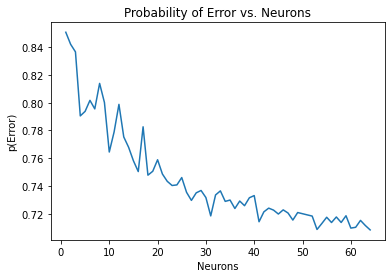

In [12]:
start = 1
trials = 64
x_ax = np.arange(start, start+trials, 1)
plt.plot(x_ax,acc)
plt.title('Probability of Error vs. Neurons')
plt.ylabel('p(Error)')
plt.xlabel('Neurons')
plt.show()

In [13]:
#Precision and recall of model
print(conf_matrix)
for i in range(len(conf_matrix)):
    recall = np.mean(conf_matrix, axis = 0)
    precision = np.mean(conf_matrix, axis = 1)

[[5042 3325 1820 1215 1231  829  824]
 [ 260  469  286  164  142  115   59]
 [ 367  799  982  630  495  296  147]
 [  58  487  944 1017  685  372  236]
 [  60   96  122  130  151  103   71]
 [  64  131  171  163  173  120   85]
 [ 130  594 1696 2612 3202 4143 4642]]


In [17]:
# summary(model,input_size=16)
print(recall)
print(precision)
summary(model, input_size=(nNeurons, input_dim))


[854.42857143 843.         860.14285714 847.28571429 868.42857143
 854.         866.28571429]
[2040.85714286  213.57142857  530.85714286  542.71428571  104.71428571
  129.57142857 2431.28571429]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 64, 64]             896
            Linear-2               [-1, 64, 64]           4,160
            Linear-3               [-1, 64, 64]           4,160
            Linear-4                [-1, 64, 7]             455
        LogSoftmax-5                [-1, 64, 7]               0
Total params: 9,671
Trainable params: 9,671
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.04
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [15]:
# Test Set
# Probability of error with 400 Neurons (Test): 0.6327493743296388
# Time (min):  5.017530063788096
# Accuracy (Test): 0.36725062567036115
# Worst Value    : 0.14285714285714285
# Percent Per Class:
# 0    14.265284
# 1    14.301037
# 2    14.301037
# 3    14.301037
# 4    14.301037
# 5    14.301037
# 6    14.229532


start = time.time()

model = TwoLayerMLP(input_dim, nNeurons, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
model = model_train(model, X_tensor_train, l_tensor_train, criterion, optimizer, num_epochs=num_epochs)
#Validate/predict it and record p(error)
Z, accTest = model_predict(model,X_tensor_test,y_test)

stop = time.time()

print('Probability of error with', nNeurons,'Neurons (Test):',accTest)
print('Time: ', stop - start) 
print('Time (min): ', (stop - start)/60) 

print('Accuracy (Test):',1-accTest)
print('Worst Value    :',1/7)

print(acc)